## Introduction
This script loads a normalized UK-DALE synthetic dataset and precess 
it with CE and FHMM algorithms.


### Imports


In [1]:
import dateutil
import pandas as pd

import sys
sys.path.insert(0, '/Users/jp/Documents/FIng/nilmtk')
sys.path.insert(0, '/Users/jp/Documents/FIng/nilmtk_metadata')

from nilmtk import DataSet, HDFDataStore
from nilmtk.disaggregate import (
    combinatorial_optimisation,
    fhmm_exact,
    hart_85
)
from nilmtk.metrics import (
    error_in_assigned_energy,
    f1_score,
    fraction_energy_assigned_correctly,
    mean_normalized_error_power
)

%matplotlib inline
from IPython.display import display


### Load the data


In [2]:
data = DataSet(
    '/Users/jp/Documents/FIng/PruebasNILM/synthetic_dataset-NEW.h5',
    format='HDF'
)
# Clear cache and avoid previous processing
data.clear_cache()

TRAIN_START = dateutil.parser.parse("2012-12-12 00:00:00")
TRAIN_END = dateutil.parser.parse("2012-12-20 00:00:00")
SAMPLE_START = dateutil.parser.parse("2012-12-14 00:00:00")
SAMPLE_END = dateutil.parser.parse("2012-12-16 00:00:00")
TEST_START = TRAIN_END
TEST_END = dateutil.parser.parse("2013-01-01 00:00:00")
b = 1

SAMPLE_PERIOD = 60


/Users/jp/anaconda3/envs/py2sci/lib/python3.6/site-packages/nilm_metadata/file_management.py:16: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  objs = yaml.load(fh)


### Train data sample


/Users/jp/anaconda3/envs/py2sci/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
/Users/jp/anaconda3/envs/py2sci/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
/Users/jp/anaconda3/envs/py2sci/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
/Users/jp/anaconda3/envs/py2sci/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
/Users/jp/anaconda3/envs/py2sci/lib/pyth

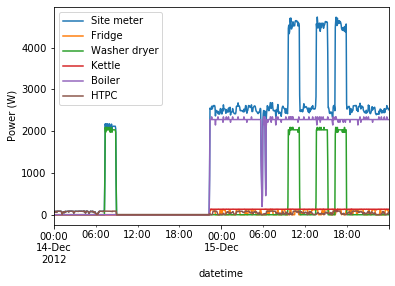

In [3]:
# Set date window to use in training
data.set_window(start=SAMPLE_START, end=SAMPLE_END)
data.buildings[b].elec.plot()


### Train and dissagregate


In [5]:
predictions = {
    "CO": {
        "file": 'temp_pred_CO-1.h5',
        "alg": combinatorial_optimisation.CombinatorialOptimisation
    },
    "FHMM": {
        "file": 'temp_pred_FHMM-1.h5',
        "alg": fhmm_exact.FHMM
    },
    # "HART85": {
    #     "file": 'temp_pred_HART-1.h5',
    #     "alg": hart_85.Hart85
    # }
}

for p, info in predictions.items():
    alg = info['alg']
    filename = info['file']

    # TRAIN
    print("> TRAINING {}".format(p))
    data.set_window(start=TRAIN_START, end=TRAIN_END)
    alg_clf = alg()
    alg_clf.train(data.buildings[b].elec, sample_period=SAMPLE_PERIOD)
    
    # TEST
    print("> TESTING {}".format(p))
    prediction_alg = HDFDataStore(filename, mode='w')
    data.set_window(start=TEST_START, end=TEST_END)
    alg_clf.disaggregate(data.buildings[b].elec, prediction_alg, sample_period=SAMPLE_PERIOD)
    prediction_alg.close()
    del prediction_alg


> TRAINING CO
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='SYNTHETIC-NORM', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='SYNTHETIC-NORM', appliances=[Appliance(type='washer dryer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='SYNTHETIC-NORM', appliances=[Appliance(type='kettle', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='SYNTHETIC-NORM', appliances=[Appliance(type='boiler', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='SYNTHETIC-NORM', appliances=[Appliance(type='HTPC', instance=1)])'
Done training!
> TESTING CO
Loading data for meter ElecMeterID(instance=6, building=1, dataset='SYNTHETIC-NORM')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=2, building=1, dataset='SYNTHETIC-NORM', appliances=[Appliance(typ

/Users/jp/Documents/FIng/nilmtk/nilmtk/metergroup.py:935: UserWarning: As a quick implementation we only get Good Sections from the first meter in the meter group.  We should really return the intersection of the good sections for all meters.  This will be fixed...
  warnings.warn("As a quick implementation we only get Good Sections from"
/Users/jp/Documents/FIng/nilmtk/nilmtk/metergroup.py:935: UserWarning: As a quick implementation we only get Good Sections from the first meter in the meter group.  We should really return the intersection of the good sections for all meters.  This will be fixed...
  warnings.warn("As a quick implementation we only get Good Sections from"


### Metrics


In [8]:
metric_funcs = (
    error_in_assigned_energy,
    f1_score,
    # fraction_energy_assigned_correctly,
    mean_normalized_error_power
)

for p,info in predictions.items():
    filename = info['file']
    print(p)
    predicted_data = DataSet(filename, format='HDF')
    predicted = predicted_data.buildings[b].elec
    gt_data = data.buildings[b].elec
    results = {}
    for m_func in metric_funcs:
        metric_func_name = m_func.__name__.replace('_', ' ')
        print("> METRIC {}".format(metric_func_name))
        result = m_func(predicted, gt_data)
        result.index = predicted.get_labels(result.index)
        results[metric_func_name] = result

    metric_results = pd.DataFrame(data=results)
    display(metric_results)
    predicted_data.store.close()


CO
> METRIC error in assigned energy
> METRIC f1 score
> METRIC mean normalized error power
FHMM
> METRIC error in assigned energy
> METRIC f1 score
> METRIC mean normalized error power


,error in assigned energy,f1 score,mean normalized error power
Fridge,active 13.43369 dtype: float64,0.446687,1.278179
Washer dryer,active 434.841367 dtype: float64,0.051215,26.464660
Kettle,active 0.091325 dtype: float64,0.835610,0.054501
Boiler,active 15.85474 dtype: float64,0.822442,0.031686
HTPC,active 1.78871 dtype: float64,0.594903,0.436225


,error in assigned energy,f1 score,mean normalized error power
Fridge,active 11.617223 dtype: float64,0.482459,1.131972
Washer dryer,active 445.642733 dtype: float64,0.051237,27.082073
Kettle,active 0.504875 dtype: float64,0.827203,0.025104
Boiler,active 15.17719 dtype: float64,0.822442,0.030614
HTPC,active 3.600177 dtype: float64,0.659995,0.368267


In [7]:
predicted_data.store.close()